In [1]:
import pandas as pd
import numpy as np
import os
from itertools import product, combinations
from random import choices

# Create data folder
os.makedirs("data", exist_ok=True)

# -------------------------
# 1. Targets and Binders
# -------------------------
n_targets = 50
targets = [f"Target_{i+1}" for i in range(n_targets)]
binders_per_target = np.random.choice([1, 2], n_targets)  # 1-2 binders per target

binder_records = []
binder_id_counter = 1

def random_seq(length=15):
    aa = list("ACDEFGHIKLMNPQRSTVWY")
    return "".join(choices(aa, k=length))

for target, n_binders in zip(targets, binders_per_target):
    for _ in range(n_binders):
        binder_records.append([f"Binder_{binder_id_counter}", target, random_seq(15)])
        binder_id_counter += 1

binders = pd.DataFrame(binder_records, columns=["binder_id", "target", "sequence"])
binders.to_csv("data/binders.csv", index=False)

# -------------------------
# 2. QC for binders (fragments)
# -------------------------
qc_frag = pd.DataFrame({
    "binder_id": binders["binder_id"],
    "sec_pct": np.round(np.random.uniform(85, 100, len(binders)), 1),
    "sds_purity": np.round(np.random.uniform(85, 100, len(binders)), 1)
})
qc_frag.to_csv("data/qc_fragments.csv", index=False)

# -------------------------
# 3. Bispecific ADCs (all pairwise target combos)
# -------------------------
target_pairs = list(combinations(targets, 2))  # unique pairs
bsadc_ids = [f"BsADC_{i+1}" for i in range(len(target_pairs))]

qc_bs = pd.DataFrame({
    "bsadc_id": bsadc_ids,
    "sec_pct": np.round(np.random.uniform(85, 100, len(bsadc_ids)), 1),
    "sds_purity": np.round(np.random.uniform(85, 100, len(bsadc_ids)), 1)
})
qc_bs.to_csv("data/qc_bispecific.csv", index=False)

# -------------------------
# 4. Cell lines (~20) with diverse lineages and expression
# -------------------------
n_cell_lines = 20
lineages = ["Lung", "Breast", "Colon", "Pancreas", "Ovary"]
cell_lines = [f"CellLine_{i+1}" for i in range(n_cell_lines)]

cell_meta_records = []
for cl in cell_lines:
    lineage = np.random.choice(lineages)
    exprs = {f"expr_{t}": np.round(np.random.uniform(0, 100), 2) for t in ["TargetA","TargetB","TargetC"]}
    cell_meta_records.append([cl, lineage, *exprs.values()])

cell_lines_df = pd.DataFrame(cell_meta_records, columns=["cell_line", "lineage", "expr_targetA", "expr_targetB", "expr_targetC"])
cell_lines_df.to_csv("data/cell_lines.csv", index=False)

# -------------------------
# 5. Dose-response for bispecific ADCs
# -------------------------
doses = [0.1, 1, 10, 100, 1000]  # nM
dose_records = []

for bs in bsadc_ids:
    for cl in cell_lines:
        base_count = np.random.randint(8000, 12000)
        for dose in doses:
            viability = base_count / (1 + (dose/50)**1.2)  # simulate sigmoid dose response
            cell_count = int(viability + np.random.normal(0, 200))
            dose_records.append([bs, cl, dose, max(cell_count, 0)])

dose_response = pd.DataFrame(dose_records, columns=["bsadc_id", "cell_line", "dose_nM", "cell_count"])
dose_response.to_csv("data/dose_response.csv", index=False)

# -------------------------
# 6. Dose-response for monospecific ADCs (all binders)
# -------------------------
mono_records = []
for binder_id in binders["binder_id"]:
    for cl in cell_lines:
        base_count = np.random.randint(8000, 12000)
        for dose in doses:
            viability = base_count / (1 + (dose/100)**1.0)
            cell_count = int(viability + np.random.normal(0, 200))
            mono_records.append([binder_id, cl, dose, max(cell_count, 0)])

monospecific = pd.DataFrame(mono_records, columns=["binder_id", "cell_line", "dose_nM", "cell_count"])
monospecific.to_csv("data/monospecific.csv", index=False)

print("Dataset generated with 50 targets, pairwise bispecifics, and 20 cell lines.")

Dataset generated with 50 targets, pairwise bispecifics, and 20 cell lines.


In [2]:
import pandas as pd
import numpy as np

binders = pd.read_csv("data/binders.csv")
qc_frag = pd.read_csv("data/qc_fragments.csv")
qc_bs = pd.read_csv("data/qc_bispecific.csv")
dose = pd.read_csv("data/dose_response.csv")
mono = pd.read_csv("data/monospecific.csv")
cells = pd.read_csv("data/cell_lines.csv")

In [4]:
# Normalize to answer:
# “How much killing occurred relative to a baseline?”

def normalize_viability(df):
    df = df.copy()

    baseline = (
        df
        .sort_values("dose_nM")
        .groupby(["bsadc_id", "cell_line"])
        .first()["cell_count"]
    )

    df["viability"] = df.apply(
        lambda r: r["cell_count"] / baseline.loc[(r.bsadc_id, r.cell_line)],
        axis=1
    )

    return df

In [6]:
# -----------------------------
# STEP 1 — Fit Dose–Response Curves
# -----------------------------
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import warnings

# 1️⃣ Normalize viability
def normalize_viability(df, compound_col):
    df = df.copy()
    baseline = (
        df.sort_values("dose_nM")
          .groupby([compound_col, "cell_line"])["cell_count"]
          .transform("first")
    )
    df["viability"] = df["cell_count"] / baseline
    return df

dose_norm = normalize_viability(dose, "bsadc_id")
mono_norm = normalize_viability(mono, "binder_id")

# 2️⃣ Define 4-parameter logistic (Hill) model
def hill_4pl(dose, bottom, top, ic50, hill):
    return bottom + (top - bottom) / (1 + (dose / ic50) ** hill)

# 3️⃣ Fit a single dose–response curve
def fit_dose_response(doses, viability):
    doses = np.asarray(doses, float)
    viability = np.asarray(viability, float)
    order = np.argsort(doses)
    doses, viability = doses[order], viability[order]

    p0 = [viability.min(), viability.max(), np.median(doses), 1.0]
    bounds = ([0, 0, 1e-6, 0.1], [1.5, 1.5, 1e6, 5])

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            popt, _ = curve_fit(hill_4pl, doses, viability,
                                p0=p0, bounds=bounds, maxfev=10000)
        bottom, top, ic50, hill = popt
        return {
            "IC50": ic50,
            "Emax": 1 - bottom,
            "AUC": np.trapz(viability, np.log10(doses)),
            "Hill": hill,
            "fit_success": True
        }
    except Exception:
        return {"IC50": np.nan, "Emax": np.nan, "AUC": np.nan,
                "Hill": np.nan, "fit_success": False}

# 4️⃣ Apply fitting to all compounds
def fit_all_curves(df, compound_col):
    records = []
    for (compound, cell_line), g in df.groupby([compound_col, "cell_line"]):
        metrics = fit_dose_response(g["dose_nM"], g["viability"])
        records.append({compound_col: compound,
                        "cell_line": cell_line,
                        **metrics})
    return pd.DataFrame(records)

# 5️⃣ Run for bispecific and monospecific datasets
bsadc_curves = fit_all_curves(dose_norm, "bsadc_id")
mono_curves  = fit_all_curves(mono_norm, "binder_id")

# 6️⃣ Inspect outputs
print("Bispecific dose-response curves:")
print(bsadc_curves.head())
print("\nMonospecific dose-response curves:")
print(mono_curves.head())

Bispecific dose-response curves:
  bsadc_id    cell_line       IC50      Emax       AUC      Hill  fit_success
0  BsADC_1   CellLine_1  43.858183  0.998253  2.600656  1.149352         True
1  BsADC_1  CellLine_10  49.285301  0.982066  2.681738  1.350323         True
2  BsADC_1  CellLine_11  57.563747  0.979026  2.867781  1.313492         True
3  BsADC_1  CellLine_12  46.101708  1.000000  2.664784  1.075725         True
4  BsADC_1  CellLine_13  42.782563  0.982214  2.630170  1.227565         True

Monospecific dose-response curves:
  binder_id    cell_line        IC50      Emax       AUC      Hill  \
0  Binder_1   CellLine_1  102.085080  0.969831  3.006093  1.163130   
1  Binder_1  CellLine_10   94.099354  0.965201  2.963981  1.112872   
2  Binder_1  CellLine_11   94.057663  1.000000  2.916446  0.918288   
3  Binder_1  CellLine_12  116.039503  1.000000  2.981684  1.162406   
4  Binder_1  CellLine_13  101.541035  1.000000  2.987575  1.162520   

   fit_success  
0         True  
1       

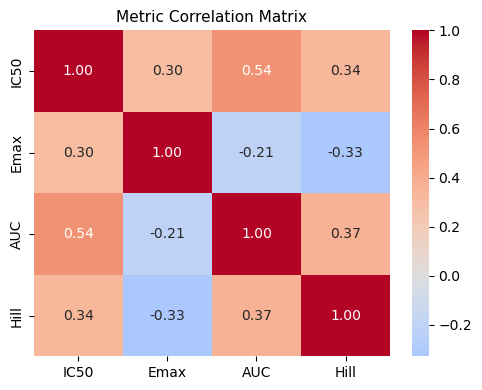

/tmp/ipykernel_1423/3291011945.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_1423/3291011945.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_1423/3291011945.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_1423/3291011945.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




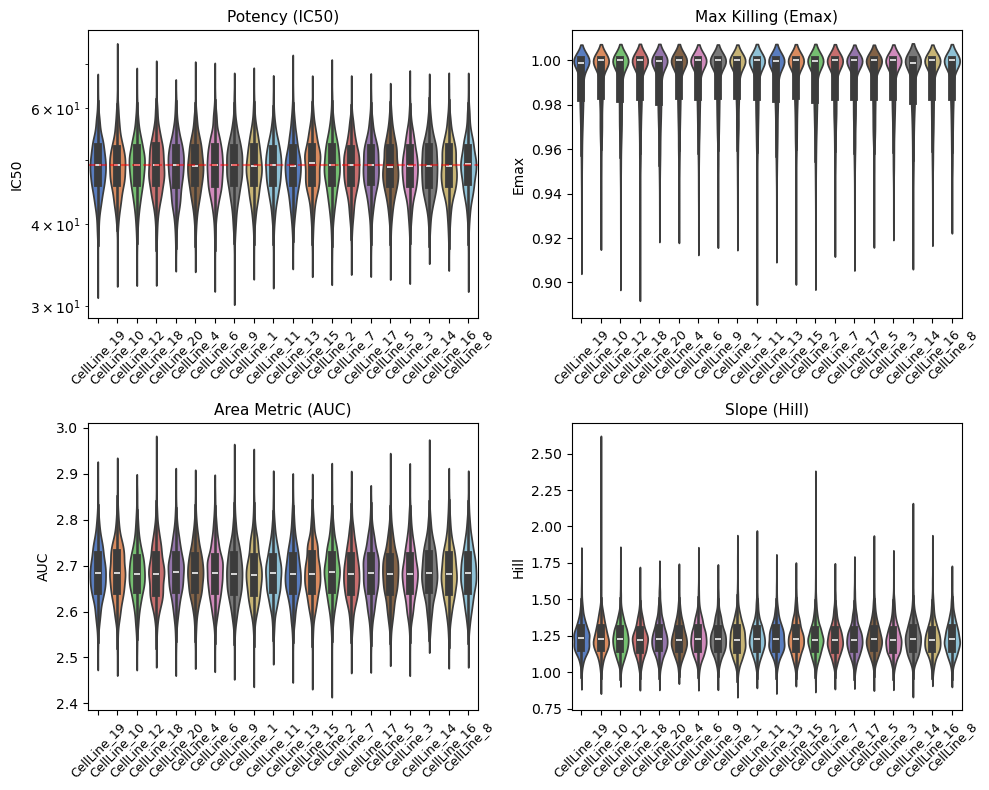

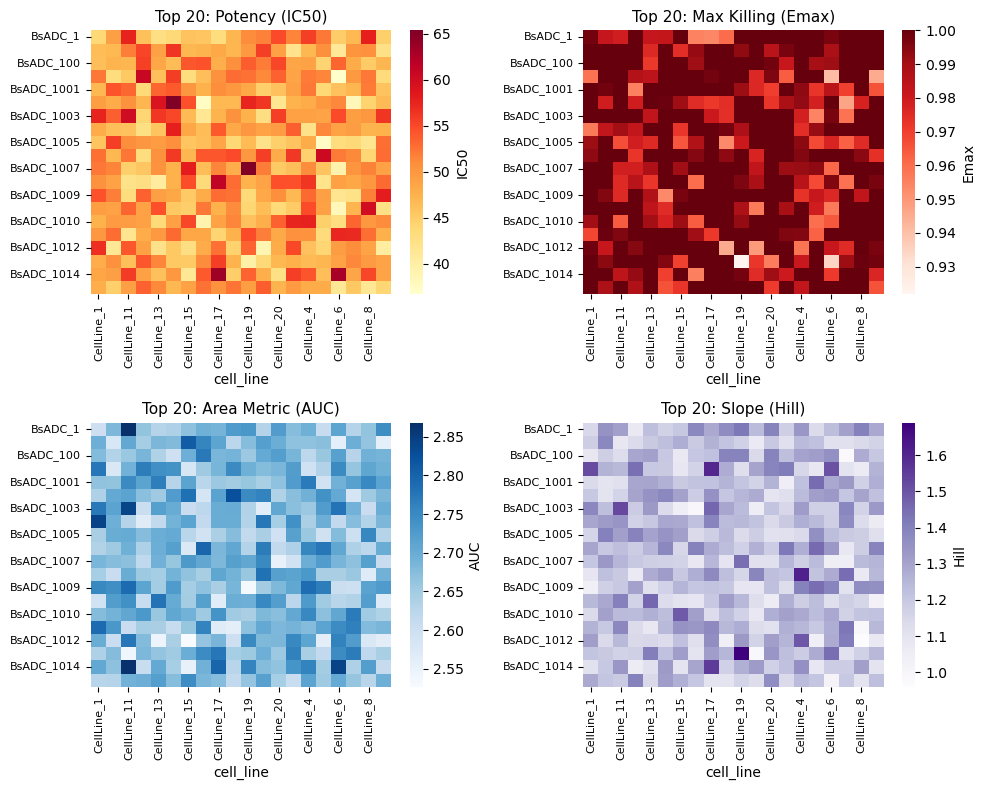

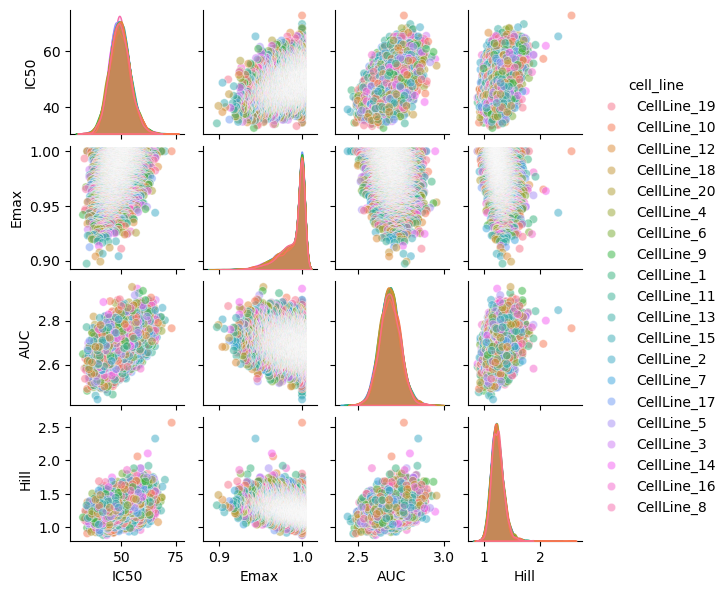

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Column names
bsadc_col, cell_line_col = "bsadc_id", "cell_line"
ic50_col, emax_col, auc_col, hill_col = "IC50", "Emax", "AUC", "Hill"
metrics = [ic50_col, emax_col, auc_col, hill_col]
titles = ["Potency (IC50)", "Max Killing (Emax)", "Area Metric (AUC)", "Slope (Hill)"]

# 0️⃣ Sorting by Emax to prioritize your top 'survivors'
# This ensures the .head(20) in heatmaps shows the most effective compounds
bsadc_curves = bsadc_curves.sort_values(by=emax_col, ascending=False)

# 1️⃣ Multivariate Pairwise Correlation Plot
# Helps identify if your "50% Killing Line" (IC50) correlates with total efficacy (Emax)
plt.figure(figsize=(5, 4))
corr_matrix = bsadc_curves[metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Metric Correlation Matrix", fontsize=11)
plt.tight_layout()
plt.show()

# 2️⃣ Distribution Plots (Violin Plots in 2x2 Grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, m in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.violinplot(x=cell_line_col, y=m, data=bsadc_curves, palette="muted", ax=ax)
    
    if m == ic50_col: 
        ax.set_yscale("log")
        # Visual reference for the median "50% Killing Line"
        ax.axhline(bsadc_curves[ic50_col].median(), color='red', linestyle='--', alpha=0.5)
        
    ax.set_title(titles[i], fontsize=11)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

# 3️⃣ Heatmaps (2x2 Grid - First 20 Rows - No Annotations)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
cmaps = ["YlOrRd", "Reds", "Blues", "Purples"]

for i, m in enumerate(metrics):
    ax = axes[i//2, i%2]
    # Pivot the data for the heatmap
    pivot_df = bsadc_curves.pivot(index=bsadc_col, columns=cell_line_col, values=m)
    
    # Plot only the first 20 rows (top survivors); annot=False for a cleaner look
    sns.heatmap(pivot_df.head(20), annot=False, cmap=cmaps[i], ax=ax, cbar_kws={'label': m})
    ax.set_title(f"Top 20: {titles[i]}", fontsize=11)
    ax.set_ylabel("")
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

# 4️⃣ Pairplot (Compact Multivariate Summary)
# This provides the full visual context of how metrics relate across cell lines
sns.pairplot(bsadc_curves, vars=metrics, hue=cell_line_col, diag_kind="kde", height=1.5, plot_kws={'alpha':0.5})
plt.show()

In [23]:
import random
import string
import datetime

def generate_blinded_id():
    """Generates ID: <3 random letters>YYYYMMDDHHMMSS<1 random letter>"""
    prefix = ''.join(random.choices(string.ascii_letters, k=3))
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    suffix = random.choice(string.ascii_letters)
    return f"{prefix}{timestamp}{suffix}"

# Example Usage
print(generate_blinded_id()) # Output: aBz202601152240Q

vyA20260115224453x
